<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20I%20%3A%20Methods%20%26%20Technologies%20for%20Business%20Analytics/Chapter%207%3A%20Text%20Analytics/7_6_3_Deep_Learning_Based_Sentiment_Analysis_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis (Opinion Mining)**
## **Deep Learning Based Sentiment Analysis**

### Word2Vec

The solution of metal news sentiment analysis with word2vec is not explained in Sentiment Analysis in the book. However, sentiment analysis is a subtask of text classification and Word2Vec solution is explained under Text Classification. We would like to share adapted version of it below.

First start with checking necessary libraries:

In [ ]:
!pip install keras
!pip install tensorflow

In [ ]:
!pip install nnabla

     |████████████████████████████████| 18.7 MB 19 kB/s 
     |████████████████████████████████| 131 kB 68.2 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 8.1 MB 52.4 MB/s 
     |████████████████████████████████| 138 kB 75.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import gdown
url = 'https://drive.google.com/u/0/uc?export=download&confirm=lNi_&id=1e4nFhDyHdnZedx26uey0TRHm9n8Ddtg4'
output = 'rnn_utils.py'
gdown.download(url, output, quiet=False)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=lNi_&id=1e4nFhDyHdnZedx26uey0TRHm9n8Ddtg4
To: /content/rnn_utils.py
100%|██████████| 10.5k/10.5k [00:00<00:00, 2.36MB/s]


'rnn_utils.py'

In [ ]:
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
import nnabla.utils.rnn as rnn_utils
from rnn_utils import *
from sklearn.model_selection import train_test_split

2021-11-07 09:23:50,398 [nnabla][INFO]: Initializing CPU extension...


Data  can be read now. These steps is very similar to other notebooks in sentiment analysis.

In [ ]:
url=   'https://docs.google.com/spreadsheets/d/1XXyxrd7r0mx7kyLaYHDVwh6BFJzo8cPD/edit?usp=sharing&ouid=108589602591644119588&rtpof=true&sd=true'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_excel(path)
#df = pd.read_excel('trainingdata16oct2020.xlsx')
df['summary'] = df['summary'].map(lambda x: x.lstrip('News :'))
df['summary'] = df['summary'].map(lambda x: x.lstrip('UPDATE'))
df['summary'] = df['summary'].map(lambda x: x.lstrip('METALS-'))
df.rename(columns={'sentiment':'score', 'summary':'text'}, inplace = True)
df

,text,score
0,Nickel jumps on talks of Indonesia export ban,1
1,hanghai copper hits near 2-week high on trade ...,1
2,Copper at near 2-week highs on hopes China imp...,0
3,"China's Yunnan to help firms stockpile 110,000...",1
4,RPT-UPDATE 1-China turns net aluminium importe...,1
...,...,...
1115,Copper rebounds as U.S.-Mexico deal calms nerves,1
1116,China demand hopes help aluminium to hold near...,1
1117,"RPT-COLUMN-New contracts, new platform as LME ...",1
1118,RPT-COLUMN- China's aluminium import surge a s...,-1


In [ ]:
url=   'https://docs.google.com/spreadsheets/d/145tqf2J949KGCYnH-Nx3hiaHTogiZFn4/edit?usp=sharing&ouid=108589602591644119588&rtpof=true&sd=true'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
test_df = pd.read_excel(path)
#test_df = pd.read_excel('metal news test.xlsx')
test_df['summary'] = test_df['summary'].map(lambda x: x.lstrip('News :'))
test_df['summary'] = test_df['summary'].map(lambda x: x.lstrip('UPDATE'))
test_df['summary'] = test_df['summary'].map(lambda x: x.lstrip('METALS-'))
test_df.rename(columns={'sentiment':'score', 'summary':'text'}, inplace = True)
test_df

,text,score
0,Copper at near 2-week highs on hopes China imp...,0
1,"China's Yunnan to help firms stockpile 110,000...",1
2,COLUMN-Politics trumps aluminium as U.S. reimp...,-1
3,Base metals decline on weak China demand outlook,-1
4,"ALUMINIUM FALLS TO $1,751.50/T, LOWEST SINCE...",-1
...,...,...
163,China names former Chinalco exec as industry m...,1
164,Copper edges off two-year low as Washington so...,0
165,"Uncertainty on global growth, trade war weighs...",-1
166,Copper gains after Fed chief rekindles rate cu...,1


In [ ]:
df = df.drop_duplicates().merge(test_df.drop_duplicates(), on=test_df.columns.to_list(), 
                   how='left', indicator=True, right_index = False, left_index = False)
df = df.loc[df._merge=='left_only',df.columns!='_merge']
df = df.reset_index(drop = True, inplace= False)

2021-10-27 09:03:38,869 [numexpr.utils][INFO]: NumExpr defaulting to 2 threads.


This notebook utilize 'rnn_utils.py' which needs to work on numpy arrays. So, the test and train datasets are converted to numpy arrays. 

In [ ]:
X_train = df.drop(columns=['score']).to_numpy()
y_train = df['score'].values
X_test = test_df.drop(columns=['score']).to_numpy()
y_test = test_df['score'].values

To pad to maximum length and equalize of all news length max length in the dataset is found which is 34.

In [ ]:
maxLen = len(max(X_train[:,0], key=len).split())
print(maxLen)

34


Let's look some example news with its labels in numpy array format.

In [ ]:
for idx in range(3):
    print(X_train[idx], y_train[idx])

['Nickel jumps on talks of Indonesia export ban'] 1
['hanghai copper hits near 2-week high on trade hopes'] 1
['Copper at near 2-week highs on hopes China imports could grow'] 0


In [ ]:
Y_oh_train = convert_to_one_hot(y_train, C = 3)
y_train[3]

1

In [ ]:
Y_oh_train[3]

array([0., 1., 0.])

In [ ]:
#one hot encoding example

idx = 12
print(f"News '{X_train[12]}' has label index {y_train[idx]}",)
print(f"Label index {y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

News '['Canada set to drop threat to impose retaliatory sanctions against U.S. aluminum -source']' has label index 1
Label index 1 in one-hot encoding format is [0. 1. 0.]


If you do not have Google Word2Vec in your device, you can download and unzip by uncommenting below.

In [ ]:
!pip install wget
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=6438fce27fdbcd997105ebcfb7d84f776f8a1a2ed1f055eedb9ea62244b5c17a
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
--2021-11-07 09:31:56--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.95.184
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.95.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  53.4MB/s    in 26s     

2021-11-07 09:32:22 (59.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

We continue with creating necessary dictionaries:
- **word_to_vec_map :** a word is given as a key and returns 300-dimensional corresponding vector as a value. 
- **index_to_word :** an index is given as a key and returns word as a value.
- **word_to_index :** a word is given as a key and returns its index as a value

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_googlenews_word2vec('GoogleNews-vectors-negative300.bin')

2021-11-07 09:33:32,854 [gensim.models.utils_any2vec][INFO]: loading projection weights from GoogleNews-vectors-negative300.bin
2021-11-07 09:34:38,532 [gensim.models.utils_any2vec][INFO]: loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


In [ ]:
#word_to_vec_map example

word = "reuters"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of reuters in the vocabulary is 2820784
the 289846th word in the vocabulary is Bishop_Ulama


Averaging of vectors will be applied in a sentence to match it with sentiments. An example can be seen in below:

In [ ]:
#sentence_to_avg example 

avg = sentence_to_avg("Mediterranean's food is my favorite", word_to_vec_map)
print("avg = \n", avg)

avg = 
 [-0.15332031  0.16894531 -0.04711914  0.1328125   0.01953125  0.01037598
 -0.296875    0.10595703 -0.02441406  0.15625    -0.12402344  0.02490234
 -0.00964355  0.04418945  0.0703125   0.17285156 -0.09423828  0.1484375
 -0.27929688 -0.04321289 -0.48046875  0.00151062 -0.02478027 -0.1875
  0.09765625 -0.20605469 -0.4765625   0.03063965 -0.04736328 -0.2578125
 -0.02636719 -0.06982422  0.00665283 -0.04541016 -0.0402832   0.13769531
 -0.35546875  0.22753906  0.09375     0.03637695  0.17285156  0.0390625
  0.19140625  0.25585938  0.11279297 -0.07568359 -0.09570312 -0.10693359
 -0.10107422 -0.0189209   0.10302734  0.13085938  0.14160156  0.21875
  0.23144531  0.14160156 -0.10058594  0.05297852 -0.11523438 -0.14257812
 -0.18847656 -0.2890625  -0.00561523  0.08740234  0.01165771 -0.32617188
 -0.11669922  0.20605469  0.16503906 -0.16601562 -0.25585938 -0.04370117
  0.20703125 -0.08056641 -0.20214844 -0.16796875  0.21875    -0.2109375
 -0.15332031  0.0201416   0.04321289  0.01153564  0.03

As a final step, the model is trained by assigning epoch number.

In [ ]:
pred, W, b = model(X_train, y_train, word_to_vec_map,num_iterations = 200)

Epoch: 0 --- cost = 0.9703933346161266
Accuracy: 0.5305676855895196
Epoch: 100 --- cost = 1.6461018253291135
Accuracy: 0.7478165938864629


In [ ]:
pred_test = predict(X_test, y_test, W, b, word_to_vec_map)

Accuracy: 0.6904761904761905


In [ ]:
t_n = y_test.shape[0]

(168,)
           0    1    -1
Predicted  -1.0  0.0  1.0  All
Actual                        
-1           43    1   21   65
0             6    1    5   12
1            18    1   72   91
All          67    3   98  168


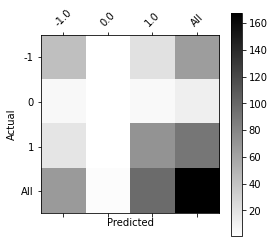

In [ ]:
print(y_test.shape)
print('           '+ '0' + '    ' + '1' + '    ' +  '-1')
print(pd.crosstab(y_test, pred_test.reshape(t_n,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(y_test, pred_test)

In [ ]:
def accuracy_per_class(preds, labels):
    
    preds_flat = preds
    labels_flat = labels

    overall_acc = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label}')
        acc = (len(y_preds[y_preds==label])/len(y_true))*100
        overall_acc += acc * len(y_preds)
        print(f'Accuracy: {acc}\n')

    print(f'Overall Accuracy: {overall_acc/len(labels)}\n')

In [ ]:
accuracy_per_class(pred_test, y_test)

Class: -1
Accuracy: 66.15384615384615

Class: 0
Accuracy: 8.333333333333332

Class: 1
Accuracy: 79.12087912087912

Overall Accuracy: 69.04761904761905



Word2Vec has slightly better performance than statistical models and relatively less accurate than deep learning based models. Although, it is not the best on acurracy metrics, it was very simple to build and train it. It could be an option for time critic applications.